# Arctic-EDS Data Preparation - Heating Degree Days

## Objectives
This notebook will execute the necessary preprocessing of data prior to being ingested into Rasdaman. The scope of this notebook will cover one "plate" in the original Environmental Atlas of Alaska. It will create two separate but related datasets, each intended to be its own coverage in Rasdaman and "plate" in the EDS. 

### Plate
#### Heating Degree Days and Degree Days Below 0°F
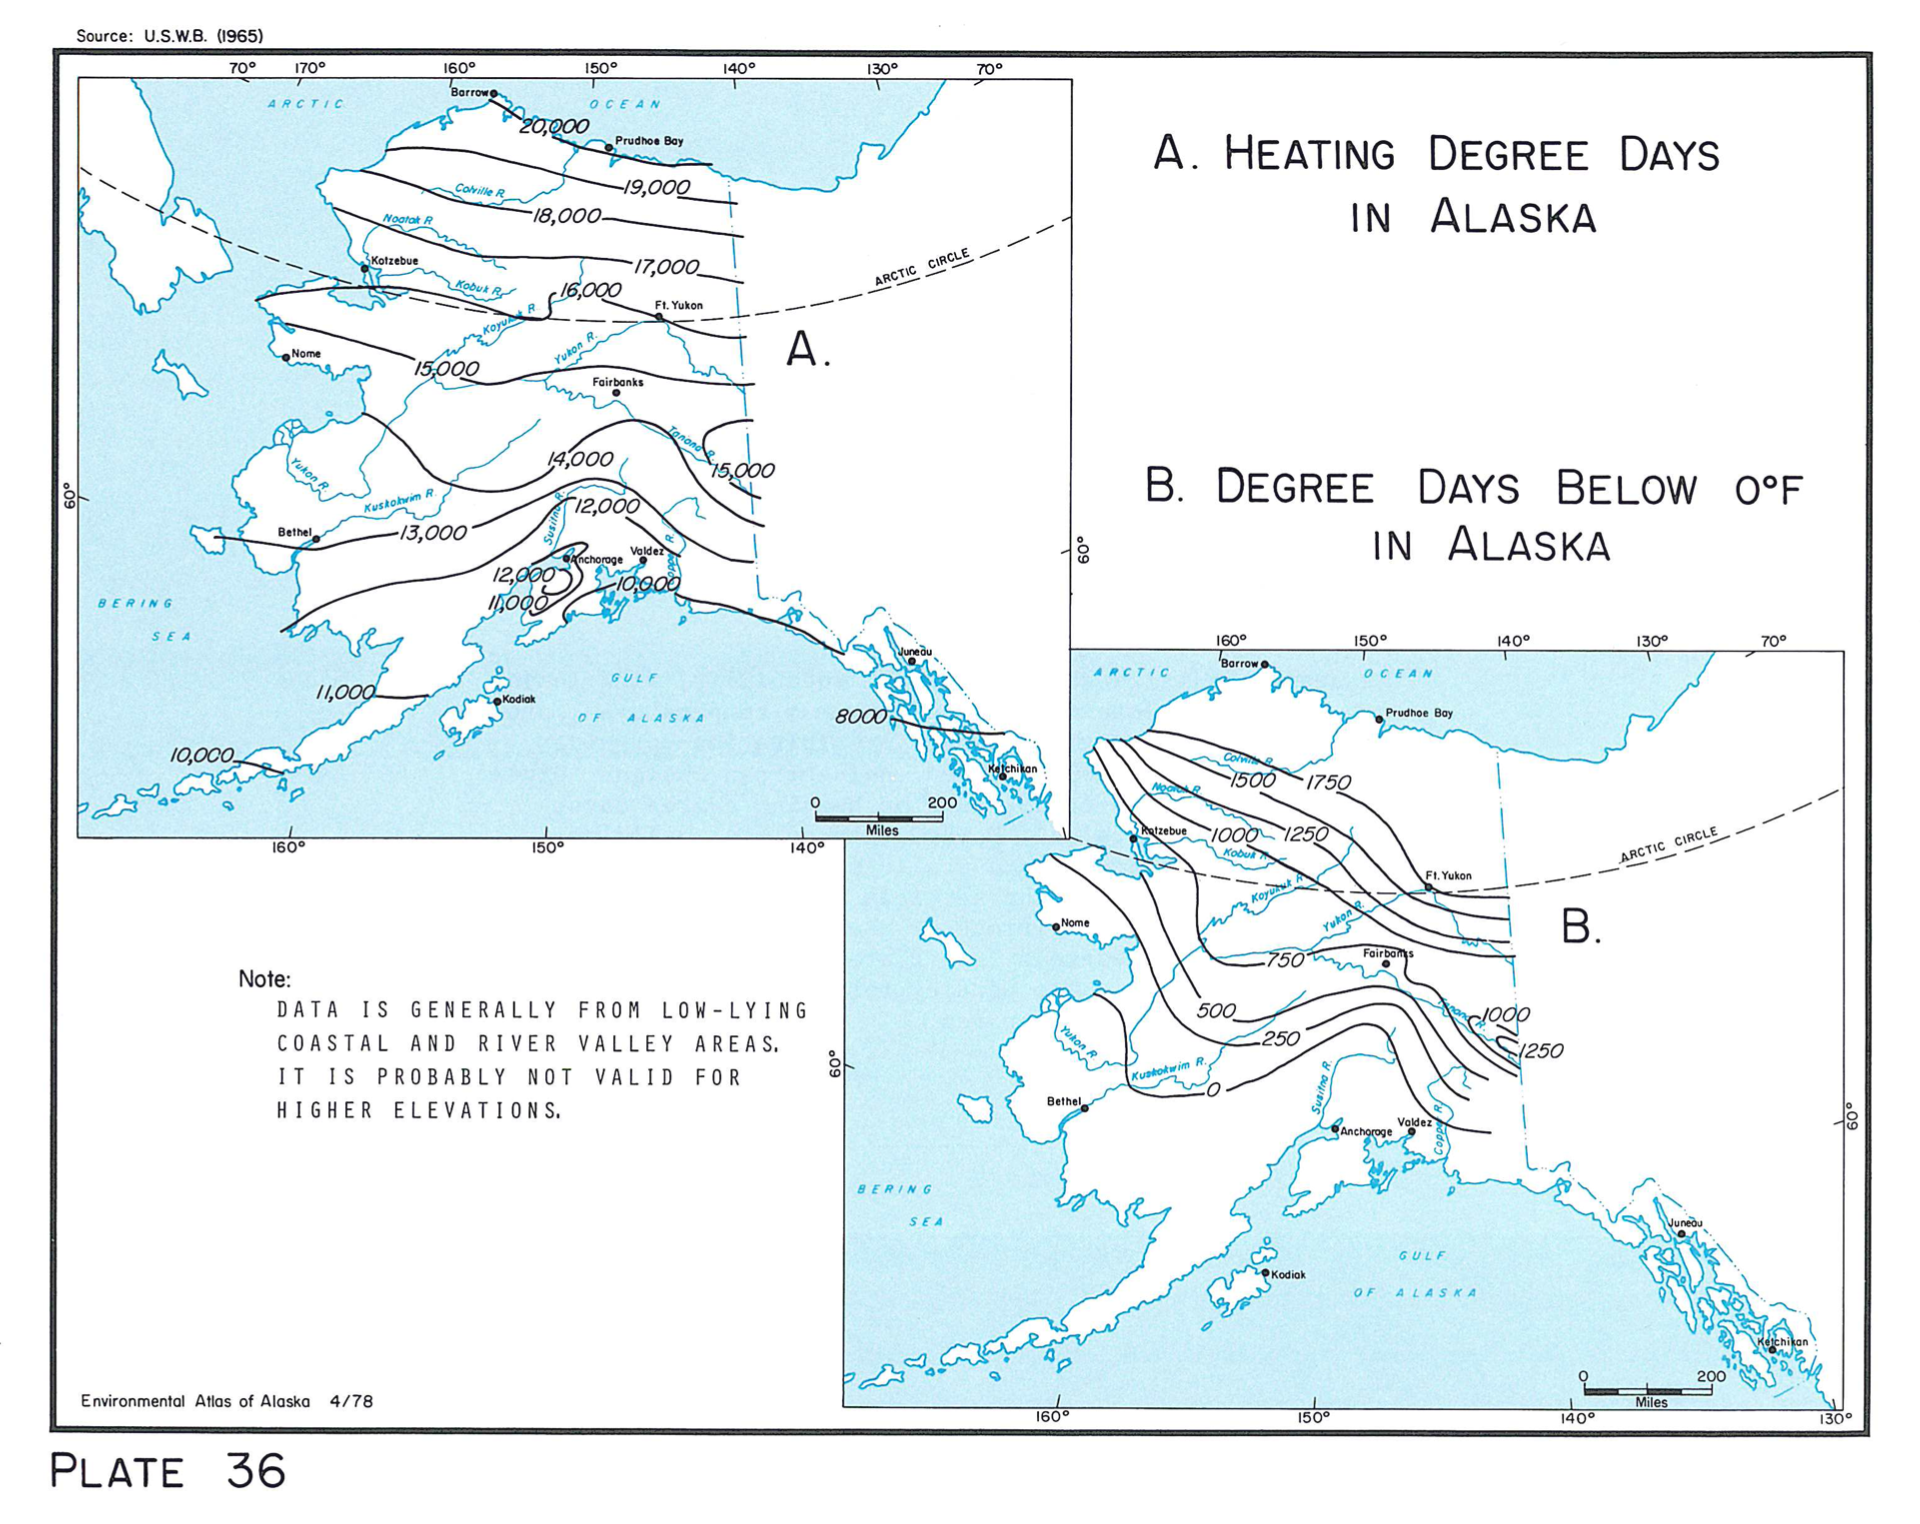

To create a modern version of this plate, we will want two coverages in Rasdaman - one for heating degree days, and one for Degree Days Below 0°F.

## Replacement Data

The replacement data for both of these new coverages will be the 20km WRF-downscaled climate data:

- CKAN entry: [Historical and Projected Dynamically Downscaled Climate Data for the State of Alaska and surrounding regions at 20km spatial resolution and hourly temporal resolution](http://ckan.snap.uaf.edu/dataset/historical-and-projected-dynamically-downscaled-climate-data-for-the-state-of-alaska-and-surrou)
- This dataset has daily mean temperature values that can be used to calculate degree days relative to any threshold
- 20 km spatial resolution.
- Range: 1970-2100
- Models: ERA-Interim (1979-2015), GFDL-CM3, NCAR-CCSM4
- Scenario: historical, RCP 8.5
 
### Structure
This dataset consists of netCDFs where each file contains a year's worth of daily 2-m air temperature values for single model and scenario.  

Both of these coverages should have the following axes (besides x and y):
 - Year
 - Model
 - Scenario (historical / RCP 85)

## Processing

The processing strategy will be to make the degree day calculations for both the "heating degree days" and "degree days below 0F" thresholds in this notebook for skae of simplicity, as the alternative would be to split this up into separate notebooks that are nearly identical except for a single value.

The model, scenario, and years that will be used are the following:
- ERA-Interim 1979-2015 (historical)
- GFDL-CM3 2016-2100 (RCP 85)
- NCAR-CCSM4 2016-2100 (RCP 85)

Make the directories for the output files:

In [1]:
# specify sratch directory for writing new data
scratch_dir = "/atlas_scratch/kmredilla/arctic_eds/"


from pathlib import Path


# directory containing daily files on Atlas
wrf_dir = Path("/rcs/project_data/wrf_data/daily/t2")

scratch_dir = Path(scratch_dir)
# heating degree day dir
hdd_dir = scratch_dir.joinpath("heating_degree_days")
hdd_dir.mkdir(exist_ok=True)
# dd below 0
ddbz_dir = scratch_dir.joinpath("degree_days_below_zero")
ddbz_dir.mkdir(exist_ok=True)

Get the proj string from the WRF files for creating a CRS and the other pieces for a rasterio "profile" for writing GeoTIFFs:

In [2]:
import numpy as np
import xarray as xr
import rasterio as rio
from pyproj.crs import CRS


wrf_fps = list(wrf_dir.glob("*.nc"))

with xr.open_dataset(wrf_fps[0]) as ds:
    crs = CRS.from_proj4(ds.attrs["proj_parameters"])
    width = ds.xc.values.shape[0]
    height = ds.yc.values.shape[0]
    transform = rio.transform.from_bounds(
        ds.xc.values.min(), 
        ds.yc.values.min(), 
        ds.xc.values.max(), 
        ds.yc.values.max(), 
        width,
        height,
    )

profile = {
    "driver": "GTiff",
    "crs": crs,
    "transform": transform,
    "width": width,
    "height": height,
    "count": 1,
    # will only be positive and should have
    # maximum of less than 30k..
    # (32850 HDD would be -25F degree every day for entire year..)
    "dtype": "int16",
    "nodata": -9999,
    "tiled": False,
    "compress": "lzw",
    "interleave": "band",
}

Define a function that will read in a file of daily values for a single year, compute the degree days below some threshold, and write to a GeoTIFF:

In [3]:
def summarize_year_dd(args):
    """Open a year's worth of daily data and compute the 
    degree days below threshold t, write results to a GeoTIFF
    """
    fp, t, profile, out_fp = args
    
    with xr.open_dataset(fp) as ds:
        # adjustment for kelvin to celsius to farenheight
        dd_arr = t - ((ds.t2.values - 273.15) * 9/5 + 32)
    dd_arr[dd_arr < 0] = 0
    dd_arr = np.round(dd_arr.sum(axis=0))
    
    with rio.open(out_fp, "w", **profile) as dst:
        dst.write(dd_arr, 1)
        
    return

Now iterate over all years / models / scenarios and process heating degree days, threshold == 65:

In [4]:
# maximum on Atlas viz nodes
ncores = 64
t = 65


from multiprocessing import Pool
from tqdm import tqdm


# we want all ERA-Interim files
wrf_fps = list(wrf_dir.glob("*ERA-Interim*.nc"))
# then CM3 and CCSM4 from 2016 onward
proj_fps = sorted(list(wrf_dir.glob("*CCSM4*rcp*.nc")) + list(wrf_dir.glob("*CM3*rcp*.nc")))
for fp in proj_fps:
    if int(fp.name.split(".")[0].split("_")[-1]) > 2015:
        wrf_fps.append(fp)

args = []
for fp in wrf_fps:
    model = fp.name.split("_")[3]
    year = fp.name.split(".")[0].split("_")[-1]
    args.append((
        fp,
        t,
        profile,
        hdd_dir.joinpath(f"heating_degree_days_{model}_{year}.tif"),
    ))

with Pool(ncores) as pool:
    _ = [
        result for result in tqdm(
            pool.imap_unordered(summarize_year_dd, args), 
            total=len(args),
        )
    ]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 207/207 [01:36<00:00,  2.15it/s]


Then do the same for degree days below zero:

In [5]:
t = 0


args = []
for fp in wrf_fps:
    model = fp.name.split("_")[3]
    year = fp.name.split(".")[0].split("_")[-1]
    args.append((
        fp,
        t,
        profile,
        ddbz_dir.joinpath(f"degree_days_below_zero_{model}_{year}.tif"),
    ))

with Pool(ncores) as pool:
    _ = [
        result for result in tqdm(
            pool.imap_unordered(summarize_year_dd, args), 
            total=len(args),
        )
    ]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 207/207 [01:36<00:00,  2.14it/s]
